In [2]:
import cftime
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import numpy as np
import om4labs
import cmocean as cmo
import seaborn as sb

In [20]:
ds_esm = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/ESM4/dic_stf_gas/clim_dic_stf_gas.nc")
ds_cm = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/odiv-251/comp_f_dic/clim_dic_stf_gas.nc")

In [21]:
ds_grid = xr.open_dataset("/work/Katherine.Turner/tempest-extremes/ESM4/data/atmos.0001010100-0005123123.slp.nc")
dA = om4labs.om4common.compute_area_regular_grid(ds_grid)

In [24]:
ds_esm

<xarray.Dataset>
Dimensions:                (time: 365, y: 180, x: 288)
Coordinates:
  * time                   (time) object 0001-01-01 00:00:00 ... 0001-12-31 0...
Dimensions without coordinates: y, x
Data variables:
    dailymean_dic_stf_gas  (time, y, x) float32 ...

Text(0, 0.5, 'mol m$^{-2}$ s$^{-1}$')

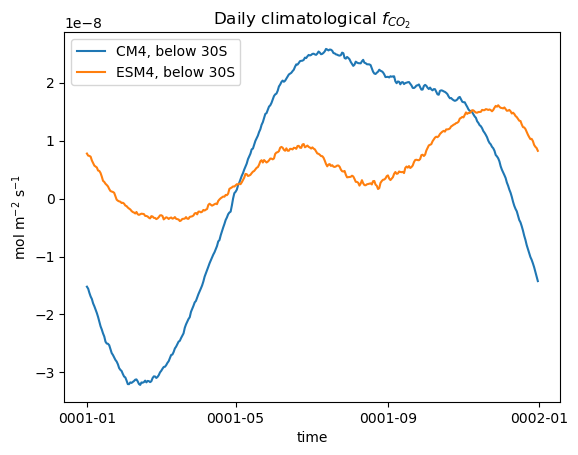

In [33]:
(((ds_cm.dailymean_dic_stf_gas[:,:60,:] * dA[:60,:]).sum(dim={'lat','lon'}))/dA[:60,:].sum()).plot(label="CM4, below 30S")
(((ds_esm.dailymean_dic_stf_gas[:,:60,:] * dA[:60,:]).sum(dim={'x','y'}))/dA[:60,:].sum()).plot(label="ESM4, below 30S")
plt.title("Daily climatological $f_{CO_2}$")
plt.legend()
plt.ylabel("mol m$^{-2}$ s$^{-1}$")

In [2]:
expname = "odiv-251"
path = f'/work/Katherine.Turner/CM4_storms/code/response'

archive_251 = "/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp"
#ds_ice = xr.open_mfdataset(f"{archive_251}/ice_1x1deg/ts/monthly/5yr/ice_1x1deg.*.EXT.nc", use_cftime=True)

ds_grid = xr.open_dataset(f"{archive_251}/ocean_monthly_1x1deg/ocean_monthly_1x1deg.static.nc")

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [3]:
ocean_area = ds_grid.areacello * ds_grid.wet

SO_area = ocean_area.sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})

In [4]:
varnames = ["hfds", "dic_stf_gas", "MLD_003"]
lim0 = [0, -1.6e-7, 0, -250, -1.6e-7, 0]
lim1 = [250, 1.6e-7, 350, 0, 1.6e-7, 350]
cmaps = [plt.get_cmap("Blues", 10), plt.get_cmap("RdBu", 10), plt.get_cmap("inferno_r", 14),
         plt.get_cmap("Reds_r", 10), plt.get_cmap("RdBu", 10), plt.get_cmap("inferno_r", 14)]

# labels for figure
units = ["W", "mol C s$^{-1}$", "m"]
varnames_long = ["heat fluxes \n (W m$^{-2}$)", "CO$_2$ fluxes \n (mol C m$^{-2}$ s$^{-1}$)", "MLD \n (m)"]
seas = ["Summer", "Winter"]
#xt = [SO_area_total.time.data[0], SO_area_total.time.data[90], SO_area_total.time.data[181], SO_area_total.time.data[273]]
#xt_labels = ["Jan-1", "Apr-1", "Jul-1", "Oct-1"]

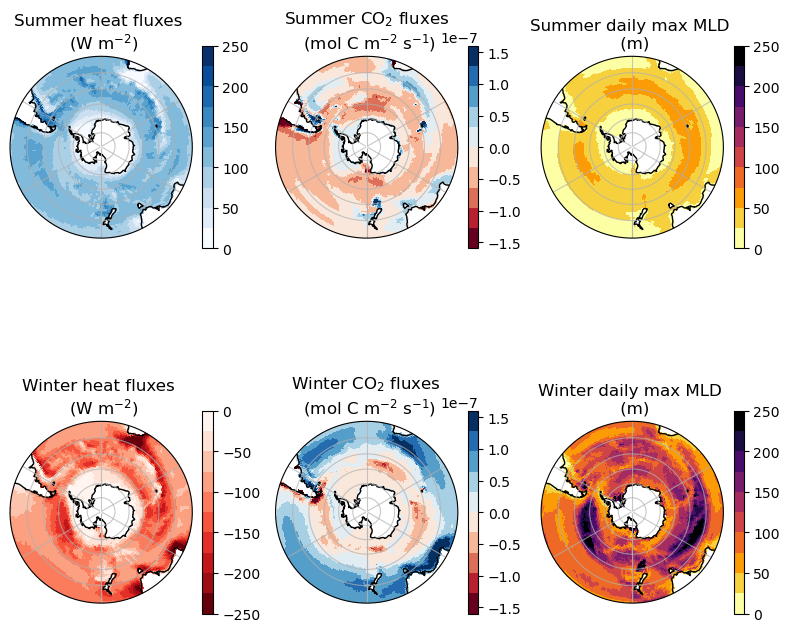

In [15]:
fig, axs = plt.subplots(figsize=(8, 8), nrows = 2, ncols = 3,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()

for i_v, v in enumerate(varnames):
    
    ds = xr.open_dataset(f'{path}/clim_{v}.nc', use_cftime=True)
#    SO_area_total = (ds[f"dailymean_{v}"]*ocean_area).sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})
    
    seasonal_means = ds[f'dailymean_{v}'].groupby(ds.time.dt.season).mean()

#    SO_area_total.plot(ax=axs[i_v])
    
    for i in np.arange(2):
    
        ibox = (i)*3+i_v
    
        f = seasonal_means[i,:,:].plot(ax=axs[ibox], transform=ccrs.PlateCarree(), add_colorbar=False,
                                       vmin=lim0[ibox], 
                                       vmax=lim1[ibox],
                                       cmap=cmaps[ibox])
        axs[ibox].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
        axs[ibox].gridlines(alpha=0.7)
        axs[ibox].set_boundary(circle, transform=axs[ibox].transAxes)
        axs[ibox].coastlines()
        axs[ibox].set_title(f"{seas[i]} {varnames_long[i_v]}")
        plt.colorbar(f, ax=axs[ibox], aspect=20, fraction = .05)
plt.tight_layout()
#plt.savefig('CM4_seasonal_climatology.png', format="png", dpi=100, bbox_inches="tight")

In [5]:
def seasonal_avg(v):
    ds = xr.open_dataset(f'{path}/clim_{v}.nc', use_cftime=True)
    SO_total = (ds[f"dailymean_{v}"]*ocean_area).sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})
    SO_avg = SO_total / SO_area
    seasonal_means = ds[f'dailymean_{v}'].groupby(ds.time.dt.season).mean()
     
    return SO_total, SO_avg, seasonal_means

In [6]:
heat_total, _, heat_seasonal = seasonal_avg("hfds")
carb_total, _, carb_seasonal = seasonal_avg("dic_stf_gas")

## Checking total period of heat release and carbon release in climatology

In [8]:
idx_heat_release = heat_total < 0
(24*60**2*heat_total[idx_heat_release]).sum()

<xarray.DataArray ()>
array(-1.39940128e+23)

In [15]:
24*60**2*12.011*carb_total.sum()

<xarray.DataArray ()>
array(1.58520525e+14)

In [9]:
idx_carb_release = carb_total < 0
(24*60**2*12.011*carb_total[idx_carb_release]).sum()

<xarray.DataArray ()>
array(-3.7174177e+14, dtype=float32)

In [7]:
times = (cftime.DatetimeNoLeap(1, 1, 1, 0, 0, 0, 0, has_year_zero=True),
         cftime.DatetimeNoLeap(1, 4, 1, 0, 0, 0, 0, has_year_zero=True),
         cftime.DatetimeNoLeap(1, 7, 1, 0, 0, 0, 0, has_year_zero=True),
         cftime.DatetimeNoLeap(1, 10, 1, 0, 0, 0, 0, has_year_zero=True),
         cftime.DatetimeNoLeap(2, 1, 1, 0, 0, 0, 0, has_year_zero=True))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


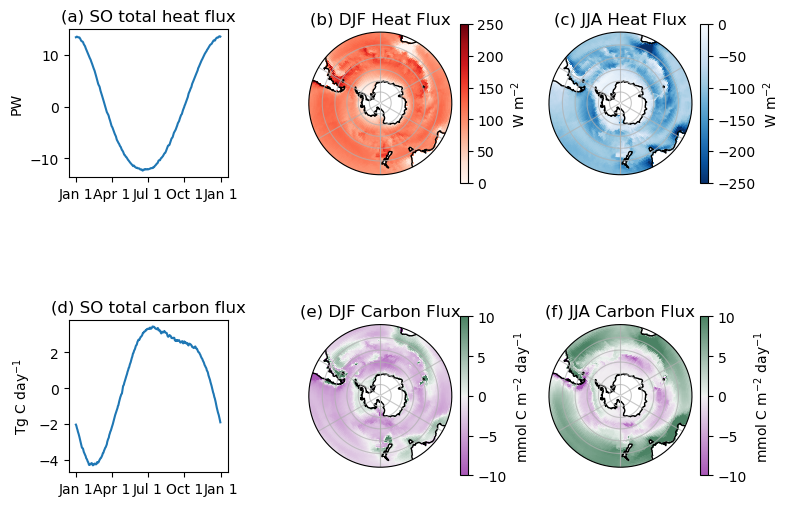

In [15]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2,3)

ax0 = fig.add_subplot(gs[0,0], adjustable="box", aspect=13)
(1e-15*heat_total).plot(ax=ax0)
ax0.set_title("(a) SO total heat flux")
ax0.set_ylabel("PW")
ax0.set_xticks(times)
ax0.set_xticklabels(["Jan 1", "Apr 1", "Jul 1", "Oct 1", "Jan 1"])
ax0.set_xlabel("")

ax1 = fig.add_subplot(gs[0,1], projection=ccrs.SouthPolarStereo())
f = heat_seasonal.sel(season="DJF").plot(ax=ax1, 
                                     transform=ccrs.PlateCarree(), 
                                     add_colorbar=False,
                                     vmin=0,
                                     vmax=250,
                                     cmap="Reds") 
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax1.gridlines(alpha=0.7)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.coastlines()
ax1.set_title(f"(b) DJF Heat Flux")
plt.colorbar(f, ax=ax1, aspect=20, fraction = .05, label="W m$^{-2}$")

ax2 = fig.add_subplot(gs[0,2], projection=ccrs.SouthPolarStereo())
f = heat_seasonal.sel(season="JJA").plot(ax=ax2, 
                                     transform=ccrs.PlateCarree(), 
                                     add_colorbar=False,
                                     vmin=-250,
                                     vmax=0,
                                     cmap="Blues_r") 
ax2.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax2.gridlines(alpha=0.7)
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.coastlines()
ax2.set_title(f"(c) JJA Heat Flux")
plt.colorbar(f, ax=ax2, aspect=20, fraction = .05, label="W m$^{-2}$")

ax3 = fig.add_subplot(gs[1,0], adjustable="box", aspect=45)
(12.011e-12*60**2*24*carb_total).plot(ax=ax3)
ax3.set_title("(d) SO total carbon flux")
ax3.set_ylabel("Tg C day$^{-1}$")
ax3.set_xticks(times)
ax3.set_xticklabels(["Jan 1", "Apr 1", "Jul 1", "Oct 1", "Jan 1"])
ax3.set_xlabel("")

ax4 = fig.add_subplot(gs[1,1], projection=ccrs.SouthPolarStereo())
f = (1e3 * 60**2 * 24 * carb_seasonal.sel(season="DJF")).plot(ax=ax4, 
                                     transform=ccrs.PlateCarree(), 
                                     add_colorbar=False,
                                     vmin=-10,
                                     vmax=10,
                                     cmap=sb.diverging_palette(300, 145, s=60, as_cmap=True)) 
ax4.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax4.gridlines(alpha=0.7)
ax4.set_boundary(circle, transform=ax4.transAxes)
ax4.coastlines()
ax4.set_title(f"(e) DJF Carbon Flux")
plt.colorbar(f, ax=ax4, aspect=20, fraction = .05, label="mmol C m$^{-2}$ day$^{-1}$")

ax5 = fig.add_subplot(gs[1,2], projection=ccrs.SouthPolarStereo())
f = (1e3 * 60**2 * 24 * carb_seasonal.sel(season="JJA")).plot(ax=ax5, 
                                     transform=ccrs.PlateCarree(), 
                                     add_colorbar=False,
                                     vmin=-10,
                                     vmax=10,
                                     cmap=sb.diverging_palette(300, 145, s=60, as_cmap=True)) 
ax5.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax5.gridlines(alpha=0.7)
ax5.set_boundary(circle, transform=ax5.transAxes)
ax5.coastlines()
ax5.set_title(f"(f) JJA Carbon Flux")
plt.colorbar(f, ax=ax5, aspect=20, fraction = .05, label="mmol C m$^{-2}$ day$^{-1}$")

plt.tight_layout()
plt.savefig("/home/Katherine.Turner/CM4_seasonal_climatology.eps", format="eps", bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/CM4_seasonal_climatology.png", format="png", dpi=100, bbox_inches="tight")

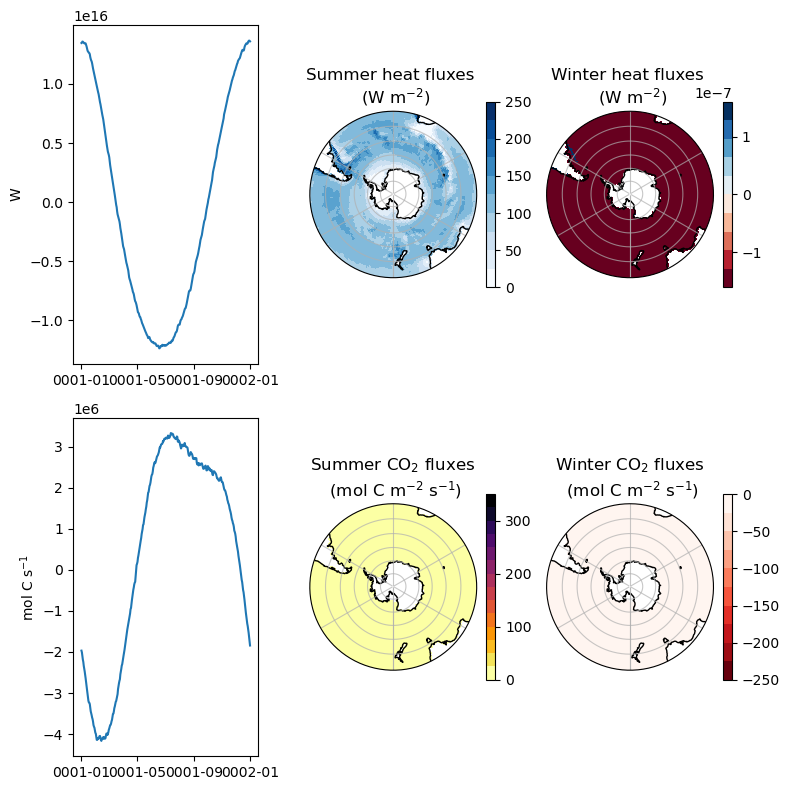

In [11]:
for i_v, v in enumerate(varnames[:2]):
    
    ds = xr.open_dataset(f'{path}/clim_{v}.nc', use_cftime=True)
    SO_total = (ds[f"dailymean_{v}"]*ocean_area).sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})
    seasonal_means = ds[f'dailymean_{v}'].groupby(ds.time.dt.season).mean()

    ax_avg = fig.add_subplot(gs[i_v,0])
    if i_v == 2:
        SO_avg = SO_total / SO_area
        SO_avg.plot(ax=ax_avg)
    else:
        SO_total.plot(ax=ax_avg)
#    ax_avg.set_xticks(xt, xt_labels)
    ax_avg.set_xlabel('')
    ax_avg.set_ylabel(units[i_v])
    
    for i in np.arange(2):
        ibox = (i_v)*2+i
    
        ax_map = fig.add_subplot(gs[i_v,i+1], projection=ccrs.SouthPolarStereo())
    
        f = seasonal_means[i,:,:].plot(ax=ax_map, transform=ccrs.PlateCarree(), 
                                    add_colorbar=False,
                                       vmin=lim0[ibox], 
                                       vmax=lim1[ibox],
                                       cmap=cmaps[ibox])        
#        if i==0:
#            ds_ice.EXT.groupby(ds_ice.time.dt.season).mean(dim="time").sel(season="DJF").plot.contour(ax=ax_map, levels=[0.2],
#                                                                                              colors="grey",transform=ccrs.PlateCarree())
#        if i==1:
#            ds_ice.EXT.groupby(ds_ice.time.dt.season).mean(dim="time").sel(season="JJA").plot.contour(ax=ax_map, levels=[0.2],
#                                                                                              colors="grey",transform=ccrs.PlateCarree())            
        ax_map.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
        ax_map.gridlines(alpha=0.7)
        ax_map.set_boundary(circle, transform=ax_map.transAxes)
        ax_map.coastlines()
        ax_map.set_title(f"{seas[i]} {varnames_long[i_v]}")
        plt.colorbar(f, ax=ax_map, aspect=20, fraction = .05)
        #ax_map.set_aspect(1)
        
    #ax_avg.set_aspect(1)
        
plt.tight_layout()
#plt.savefig('CM4_seasonal_climatology.png', format="png", dpi=100, bbox_inches="tight")

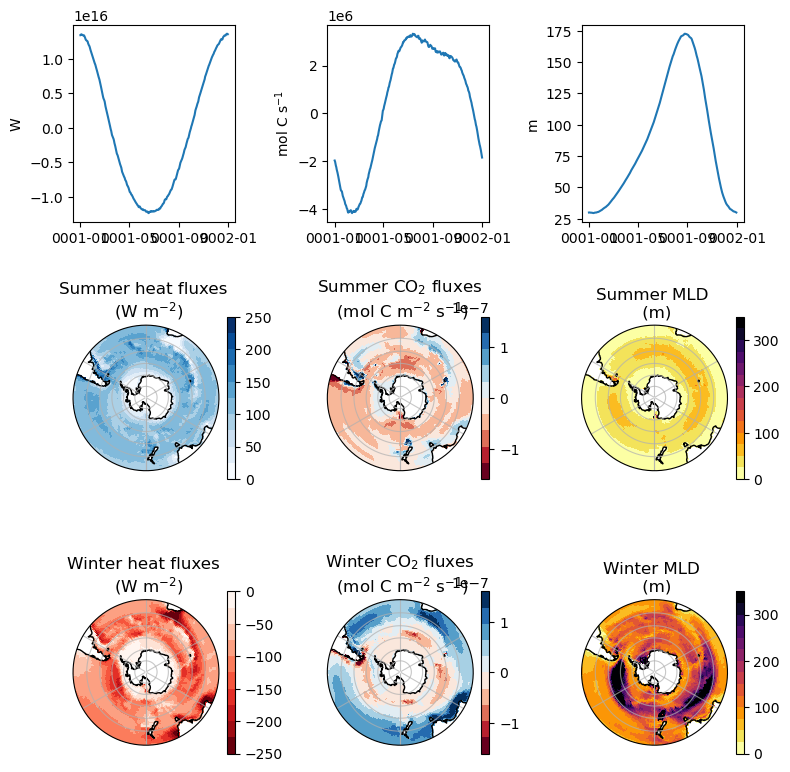

In [13]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(3,3)

for i_v, v in enumerate(varnames):
    
    ds = xr.open_dataset(f'{path}/clim_{v}.nc', use_cftime=True)
    SO_total = (ds[f"dailymean_{v}"]*ocean_area).sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})
    seasonal_means = ds[f'dailymean_{v}'].groupby(ds.time.dt.season).mean()

    ax_avg = fig.add_subplot(gs[0,i_v])
    if i_v == 2:
        SO_avg = SO_total / SO_area
        SO_avg.plot(ax=ax_avg)
    else:
        SO_total.plot(ax=ax_avg)
#    ax_avg.set_xticks(xt, xt_labels)
    ax_avg.set_xlabel('')
    ax_avg.set_ylabel(units[i_v])
    
    for i in np.arange(2):
        ibox = (i)*3+i_v
    
        ax_map = fig.add_subplot(gs[i+1,i_v], projection=ccrs.SouthPolarStereo())
    
        f = seasonal_means[i,:,:].plot(ax=ax_map, transform=ccrs.PlateCarree(), 
                                    add_colorbar=False,
                                       vmin=lim0[ibox], 
                                       vmax=lim1[ibox],
                                       cmap=cmaps[ibox])        
#        if i==0:
#            ds_ice.EXT.groupby(ds_ice.time.dt.season).mean(dim="time").sel(season="DJF").plot.contour(ax=ax_map, levels=[0.2],
#                                                                                              colors="grey",transform=ccrs.PlateCarree())
#        if i==1:
#            ds_ice.EXT.groupby(ds_ice.time.dt.season).mean(dim="time").sel(season="JJA").plot.contour(ax=ax_map, levels=[0.2],
#                                                                                              colors="grey",transform=ccrs.PlateCarree())            
        ax_map.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
        ax_map.gridlines(alpha=0.7)
        ax_map.set_boundary(circle, transform=ax_map.transAxes)
        ax_map.coastlines()
        ax_map.set_title(f"{seas[i]} {varnames_long[i_v]}")
        plt.colorbar(f, ax=ax_map, aspect=20, fraction = .05)
plt.tight_layout()
plt.savefig('CM4_seasonal_climatology.png', format="png", dpi=100, bbox_inches="tight")

## Redo calculation using 1985-2014 historical run

In [2]:
path_hist = "/work/Katherine.Turner/tempest-extremes/CM4_historical/"
ds_heat = xr.open_mfdataset(f"{path_hist}/hfds/*hfds.nc", use_cftime=True)
ds_co2 = xr.open_mfdataset(f"{path_hist}/co2flux/*dic_stf_gas.nc", use_cftime=True)
ds_mld = xr.open_mfdataset(f"{path_hist}/mld/*MLD_003.nc", use_cftime=True)

seasonal_heat = ds_heat.hfds.groupby(ds_heat.time.dt.season).mean()
seasonal_co2 = ds_co2.dic_stf_gas.groupby(ds_co2.time.dt.season).mean()
seasonal_mld = ds_mld.MLD_003.groupby(ds_mld.time.dt.season).mean()

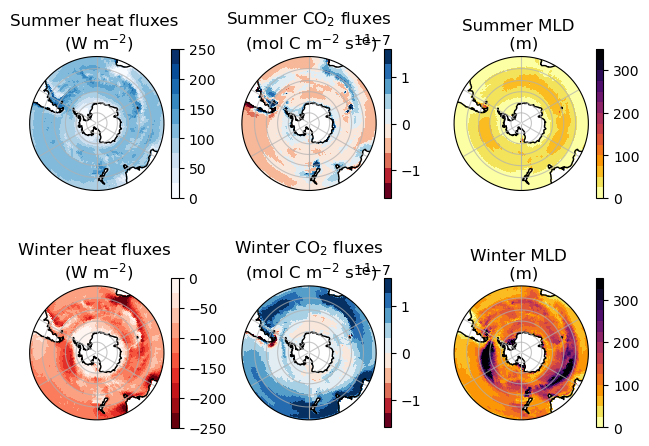

In [25]:
fig, a = plt.subplots(ncols=3, nrows=2, subplot_kw={'projection':ccrs.SouthPolarStereo()})
a = a.flatten()

f = seasonal_heat[0,:,:].plot(ax=a[0], transform=ccrs.PlateCarree(), vmin=0, vmax=250, cmap=plt.get_cmap("Blues", 10), add_colorbar=False)
plt.colorbar(f, ax=a[0], aspect=20, fraction = .05)
f = seasonal_co2[0,:,:].plot(ax=a[1], transform=ccrs.PlateCarree(), vmin=-1.6e-7, vmax=1.6e-7, cmap=plt.get_cmap("RdBu", 10), add_colorbar=False) 
plt.colorbar(f, ax=a[1], aspect=20, fraction = .05)
f = seasonal_mld[0,:,:].plot(ax=a[2], transform=ccrs.PlateCarree(), vmin=0, vmax=350, cmap = plt.get_cmap("inferno_r", 14), add_colorbar=False) 
plt.colorbar(f, ax=a[2], aspect=20, fraction = .05)

f = seasonal_heat[1,:,:].plot(ax=a[3], transform=ccrs.PlateCarree(), vmin=-250, vmax=0, cmap=plt.get_cmap("Reds_r", 10), add_colorbar=False)  
plt.colorbar(f, ax=a[3], aspect=20, fraction = .05)
f = seasonal_co2[1,:,:].plot(ax=a[4], transform=ccrs.PlateCarree(), vmin=-1.6e-7, vmax=1.6e-7, cmap=plt.get_cmap("RdBu", 10), add_colorbar=False) 
plt.colorbar(f, ax=a[4], aspect=20, fraction = .05)
f = seasonal_mld[1,:,:].plot(ax=a[5], transform=ccrs.PlateCarree(), vmin=0, vmax=350, cmap = plt.get_cmap("inferno_r", 14), add_colorbar=False) 
plt.colorbar(f, ax=a[5], aspect=20, fraction = .05)

for i in np.arange(6):
    a[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    a[i].gridlines(alpha=0.7)
    a[i].set_boundary(circle, transform=a[i].transAxes)
    a[i].coastlines()
    a[i].set_title(f"{seas[int(np.round((i+1)/6))]} {varnames_long[i%3]}")
plt.tight_layout()
plt.savefig('CM4_seasonal_climatology_historical.png', format="png", dpi=100, bbox_inches="tight")

In [ ]:
# adding fronts from Becki's data
path_orsi = '/home/Rebecca.Beadling/BAMS_SOTC2021_SO/SST_Mixed_Layer_Analysis/data/orsi_fronts'

path_ocean_annual = "/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual/ts/annual/5yr"

ds_t = xr.open_mfdataset(f"{path_ocean_annual}/*thetao.nc", use_cftime=True)
ds_s = xr.open_mfdataset(f"{path_ocean_annual}/*.so.nc", use_cftime=True)
ds_z = xr.open_mfdataset(f"{path_ocean_annual}/*.zos.nc", use_cftime=True)

t_avg = ds_t.thetao.sel(zl=0, method="nearest").mean(dim="time")

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
t_avg.differentiate("yh").plot(transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=plt.get_cmap("RdBu"))
axs.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs.gridlines(alpha=0.7)
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
ds_z.zos.mean(dim="time").plot(transform=ccrs.PlateCarree(), cmap=plt.get_cmap("Reds", 10))
axs.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs.gridlines(alpha=0.7)
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
ds_t.thetao.sel(zl=100, method="nearest").mean(dim="time").plot(transform=ccrs.PlateCarree(), vmin=0, vmax=10, cmap=plt.get_cmap("Reds", 10))
ds_t.thetao.sel(zl=100, method="nearest").mean(dim="time").plot.contour(levels=[6.75],colors="black",transform=ccrs.PlateCarree())
axs.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs.gridlines(alpha=0.7)
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
ds_s.so.sel(zl=100, method="nearest").mean(dim="time").plot(transform=ccrs.PlateCarree(), vmin=34, vmax=35.5)
ds_s.so.sel(zl=100, method="nearest").mean(dim="time").plot.contour(levels=[34.8],colors="black",transform=ccrs.PlateCarree())
axs.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs.gridlines(alpha=0.7)
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()